### EE 421/521 Image Processing - Spring 2020-21

## Project 7 - Geometric Transformations

#### Submission deadline: 12 April 2021

In this project, you will implement the following:

1. Calculate affine mapping parameters between two triangles
2. Geometrically transform an image into a trapezoid shape using two affine mappings 

**This project will be graded for both EE 421 (HW6) and EE 521 (HW6) students.**

*Copyright (c) 2021 by Arif Tanju Erdem*

************************************
Neva Yaren Bulut
************************************

In [31]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib as mpl
import matplotlib.pyplot as plt

# array operations
import numpy as np

# signal processing operations
from scipy import signal

# mathematical calculations
import math

In [32]:
# display an image in original size (new version)
# from: https://stackoverflow.com/questions/28816046/
# displaying-different-images-with-actual-size-in-matplotlib-subplot

def my_display_actual_size(img, str_caption):
    
    dpi = mpl.rcParams['figure.dpi']
    height, width = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    # ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.title(str_caption)
    plt.show()

    return

# end of function

In [33]:
# my function to convert to lumincance, round to nearest integer, 
# truncate to range [0, 255], and then set data

def my_imgLuminance(imgRGB):
    
    # make sure it is a color image
    dim_img = imgRGB.shape[2]    
    assert dim_img >= 3
    
    # get the luminance data
    if dim_img == 3:
        imgLum = color.rgb2gray(imgRGB)
    else:
        # ignore the alpha channel
        imgLum = color.rgb2gray(imgRGB[:,:,0:3])

    imgLum = np.round(imgLum * 255, 0)
    imgLum = np.minimum(imgLum, 255)
    imgLum = np.maximum(imgLum, 0)
    imgLum = imgLum.astype('uint8')
    
    return imgLum

# end of function

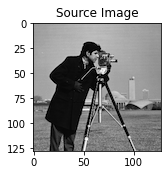

In [34]:
# set image folder
image_folder = r'D:\yeni\Dersler\EE421-imageprocessing\images'

# read input image 
image_file = r'/cameraman_128.tiff'
image_path = image_folder + image_file
imgSource = io.imread(image_path)

if imgSource.ndim == 3:
    # calculate the luminance image
    img = my_imgLuminance(imgSource)
else:
    img = imgSource

# display source image
my_display_actual_size(imgSource,'Source Image')

In [35]:
# my function for bilinear interpolation

def my_BilinearInterp(img, x, y):
    
    # find the four nearest integer locations
    xL = int(math.floor(x))
    xH = int(math.ceil(x))
    yL = int(math.floor(y))
    yH = int(math.ceil(y))
    
    # get the four nearest pixel values
    A = img[yL,xL]  
    B = img[yL,xH]  
    C = img[yH,xL]  
    D = img[yH,xH]  

    # calculate the delta values
    dx = x - xL
    dy = y - yL

    # calculate the interpolated image value
    valInterp = (1-dy) * ((1-dx)*A + dx*B) + dy * ((1-dx)*C + dx*D)
    
    return valInterp

# end of function

In [36]:
# my function for image warping using a 3x3 geometric transformation matrix

def my_warpImage(imgSource, matForward, isBackwardMapping, interpType = 'Nearest'):
    
    # get image dimensions
    srcHeight, srcWidth = imgSource.shape
    
    assert matForward.shape == (3,3)
    
    # determine source image center
    srcCenterX = srcWidth//2
    srcCenterY = srcHeight//2

    # UL: upper-left corner, UR: upper-right corner
    # LL: lower-left corner, UR: lower-right corner
    srcCornerUL = np.array([-srcCenterX, srcCenterY, 1])
    srcCornerUR = np.array([ srcCenterX, srcCenterY, 1])
    srcCornerLL = np.array([-srcCenterX,-srcCenterY, 1])
    srcCornerLR = np.array([ srcCenterX,-srcCenterY, 1])
    
    # transform the corners
    trgCornerUL = np.dot(matForward,srcCornerUL)
    trgCornerUR = np.dot(matForward,srcCornerUR)
    trgCornerLL = np.dot(matForward,srcCornerLL)
    trgCornerLR = np.dot(matForward,srcCornerLR)
    
    # find minimum & maximum x & y values
    minX = int(round(min(trgCornerUL[0], trgCornerUR[0], trgCornerLL[0], trgCornerLR[0]),0))
    maxX = int(round(max(trgCornerUL[0], trgCornerUR[0], trgCornerLL[0], trgCornerLR[0]),0))
    minY = int(round(min(trgCornerUL[1], trgCornerUR[1], trgCornerLL[1], trgCornerLR[1]),0))
    maxY = int(round(max(trgCornerUL[1], trgCornerUR[1], trgCornerLL[1], trgCornerLR[1]),0))
    
    # determine target image area
    trgWidth = maxX - minX + 1
    trgHeight = maxY - minY + 1
    
    # pick a bigger image size to account for translation
    shiftX = int(matForward[0,2])
    shiftY = int(matForward[1,2])
    trgWidth += abs(shiftX)
    trgHeight += abs(shiftY)

    # determine the target image center    
    trgCenterX = trgWidth//2
    trgCenterY = trgHeight//2

    # create target image array
    imgTarget = np.zeros((trgHeight, trgWidth))
    
    if isBackwardMapping == False: # forward mapping
        
        # map source pixels into target image using FORWARD mapping
        # start with the top-most row
        srcY = srcCenterY
        for row in imgSource:
            # start with the left-most pixel on the current row
            srcX = -srcCenterX
            for pixel in row:
                # set pixel location
                srcPixel = np.array([srcX, srcY, 1])
                # map the pixel location to the target image
                trgPixel = np.dot(matForward, srcPixel)
                # shift by the center and flip the y axis to find actual pixel location
                # round the location to integer to find the nearest pixel location in the target image
                trgX = int(np.round(trgPixel[0]+trgCenterX-shiftX//2,0))
                trgY = int(np.round(trgPixel[1]+trgCenterY-shiftY//2,0))
                trgY = trgHeight - trgY
                # if within bounds assign values
                if trgY < trgHeight and trgY >= 0 and trgX < trgWidth and trgX >= 0:
                    # assign the target pixel value
                    imgTarget[trgY,trgX] = pixel

                # move to the next pixel to the right
                srcX += 1

            # move to the next row below
            srcY -= 1
            
        # end of loop
            
    else: # backward mapping
        
        # find backward mapping matrix by taking inverse of the forward mapping
        matBackward = np.linalg.inv(matForward)

        # map source pixels into target image using BACKWARD mapping
        # start with the top-most row
        trgY = trgCenterY
        for n in range(trgHeight):
            # start with the left-most pixel on the current row
            trgX = -trgCenterX
            for m in range(trgWidth):
                # set pixel location
                trgPixel = np.array([trgX+shiftX//2, trgY+shiftY//2, 1])
                # map the pixel location to source image
                srcPixel = np.dot(matBackward, trgPixel)
                # shift by the center and flip the y axis to find actual pixel location
                srcXfloat = srcPixel[0]+srcCenterX
                srcYfloat = srcPixel[1]+srcCenterY
                srcYfloat = srcHeight - srcYfloat

                # find nearest integer location
                srcX = int(round(srcXfloat,0))
                srcY = int(round(srcYfloat,0))
                # check if source location is within image bounds
                # use a 1 pixel marging for bilinear mapping
                if srcY < srcHeight-1 and srcY > 0 and srcX < srcWidth-1 and srcX > 0:
                    # assign the target pixel value
                    if interpType == 'Bilinear':
                        imgTarget[n,m] = my_BilinearInterp(imgSource, srcXfloat, srcYfloat)
                    else: #default is NearestNeighbor
                        imgTarget[n,m] = imgSource[srcY,srcX]
                        
                # move to the next pixel to the right
                trgX += 1

            # move to the next row below
            trgY -= 1
            
        # end of loop

    return imgTarget

# end of my function

Affine mapping parameter:
 [[1. ]
 [0. ]
 [1. ]
 [0.5]
 [2.5]
 [0. ]]

Affine trasformation matrix :
 [[1.  0.  1. ]
 [0.5 2.5 0. ]
 [0.  0.  1. ]]

matAffineBack :
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


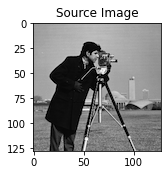

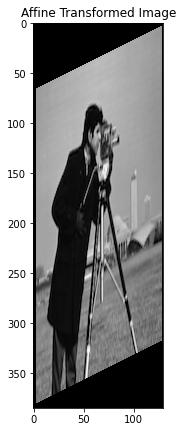

In [37]:
# STEP 1. Find affine mapping parameters between two triangular regions

# source triangle's A, B, C corners
#                u1,v1       u2,v2      u3,v3
srcTriangle = ((0.0, 0.0), (2.0, 0.0), (1.0, 1.0))
# target triangle's A, B, C corners
#               x1,y1       x2,y2       x3,y3
trgTriangle = ((1.0, 0.0), (3.0, 1.0), (2.0, 3.0))

#---------------------------------------------------------------
# Calculate and print the affine matrix for backward mapping (from target triangle to source triangle)
#---------------------------------------------------------------

# ADD YOUR CODE HERE

#calculating affine parameter
source_cor=np.array([[srcTriangle[0][0],srcTriangle[0][1],1,0,0,0],
                     [0,0,0,srcTriangle[0][0],srcTriangle[0][1],1],
                     [srcTriangle[1][0],srcTriangle[1][1],1,0,0,0],
                     [0,0,0,srcTriangle[1][0],srcTriangle[1][1],1],
                     [srcTriangle[2][0],srcTriangle[2][1],1,0,0,0],
                     [0,0,0,srcTriangle[2][0],srcTriangle[2][1],1]])
target_cor=np.array([[trgTriangle[0][0]],
                     [trgTriangle[0][1]],
                     [trgTriangle[1][0]],
                     [trgTriangle[1][1]],
                     [trgTriangle[2][0]],
                     [trgTriangle[2][1]]])


affine_parameter=np.matmul(np.linalg.inv(source_cor),target_cor)
print("Affine mapping parameter:\n",affine_parameter)

# matAffineBack = ...

# get image width & height
height, width = imgSource.shape

# define the 3x3 transformation matrix
matTrans_aff = np.array([[ affine_parameter[0][0], affine_parameter[1][0], affine_parameter[2][0]],
                         [ affine_parameter[3][0], affine_parameter[4][0], affine_parameter[5][0]],
                         [ 0.0, 0.0, 1.0]])
print("\nAffine trasformation matrix :\n",matTrans_aff)

matAffineBack =my_warpImage( imgSource, matTrans_aff, True, 'Bilinear')
#np.asarray(trgTriangle).shape

# print matAffineBack ...
print("\nmatAffineBack :\n",matAffineBack)
my_display_actual_size(imgSource,'Source Image')
my_display_actual_size(matAffineBack,'Affine Transformed Image')



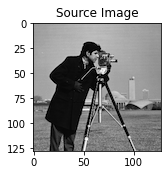

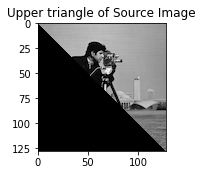

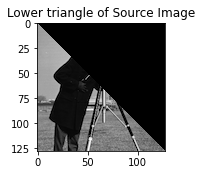

Affine mapping parameter:
 [[ 1.4]
 [-0.2]
 [ 0. ]
 [ 0. ]
 [ 0.8]
 [ 0. ]]

Affine trasformation matrix1 :
 [[ 1.4 -0.2  0. ]
 [ 0.   0.8  0. ]
 [ 0.   0.   1. ]]

Affine trasformation matrix2 :
 [[ 1.4 -0.2  0. ]
 [ 0.   0.8  0. ]
 [ 0.   0.   1. ]]


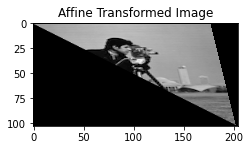

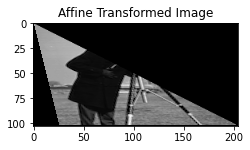

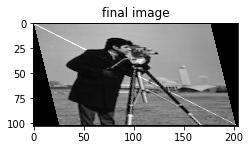

In [38]:
# STEP 2. Divide an image into two triangles and map its content with two affine mappings

# set image folder
image_folder = r'D:\yeni\Dersler\EE421-imageprocessing\images'

# read input image 
image_file = r'/cameraman_128.tiff'
image_path = image_folder + image_file
imgSource = io.imread(image_path)

if imgSource.ndim == 3:
    # calculate the luminance image
    img = my_imgLuminance(imgSource)
else:
    img = imgSource

# get image width and height
height, width = imgSource.shape

# define source & target image support
srcQuad = ((0.0, 0.0), (width, 0.0), (width, height), (0.0, height))
trgQuad = ((0.0, 0.0), (width*1.4, 0.0), (width*1.2, height*0.8), (width*0.2, height*0.8))


#---------------------------------------------------------------
# Calculate and print the two affine matrices from target image to source image
#---------------------------------------------------------------

# ADD YOUR CODE HERE

#I divide the picture to two triangle
my_display_actual_size(imgSource,'Source Image')

upper_triangle=np.copy(imgSource)
upper_triangle=np.triu(upper_triangle)
my_display_actual_size(upper_triangle,'Upper triangle of Source Image')

lower_triangle=np.copy(imgSource)
lower_triangle=np.tril(lower_triangle)
my_display_actual_size(lower_triangle,'Lower triangle of Source Image')

# matAffineBack_1 = ...
# matAffineBack_2 = ...


#calculating affine parameter
source_cor=np.array([[srcQuad[0][0],srcQuad[0][1],1,0,0,0],
                     [0,0,0,srcQuad[0][0],srcQuad[0][1],1],
                     [srcQuad[1][0],srcQuad[1][1],1,0,0,0],
                     [0,0,0,srcQuad[1][0],srcQuad[1][1],1],
                     [srcQuad[2][0],srcQuad[2][1],1,0,0,0],
                     [0,0,0,srcQuad[2][0],srcQuad[2][1],1]])
target_cor=np.array([[trgQuad[0][0]],
                     [trgQuad[0][1]],
                     [trgQuad[1][0]],
                     [trgQuad[1][1]],
                     [trgQuad[2][0]],
                     [trgQuad[2][1]]])

affine_parameter=np.matmul(np.linalg.inv(source_cor),target_cor)
print("Affine mapping parameter:\n",affine_parameter)

matTrans_aff = np.array([[ affine_parameter[0][0], affine_parameter[1][0], affine_parameter[2][0]],
                         [ affine_parameter[3][0], affine_parameter[4][0], affine_parameter[5][0]],
                         [ 0.0, 0.0, 1.0]])
# print matAffineBack_1 ...
# print matAffineBack_2 ...

print("\nAffine trasformation matrix1 :\n",matTrans_aff) # affine transformation matrix are same 
print("\nAffine trasformation matrix2 :\n",matTrans_aff)


#---------------------------------------------------------------
# Obtain the affine mapped image using backward mapping and bilinear interpolation
#---------------------------------------------------------------

# ADD YOUR CODE HERE

# imgTarget = ...
matAffineBack_1 =my_warpImage( upper_triangle, matTrans_aff, True, 'Bilinear')
matAffineBack_2 =my_warpImage( lower_triangle, matTrans_aff, True, 'Bilinear')
new_image=matAffineBack_1+matAffineBack_2

# display imgSource & imgTarget ...
my_display_actual_size(matAffineBack_1,'Affine Transformed Image')
my_display_actual_size(matAffineBack_2,'Affine Transformed Image')
my_display_actual_size(new_image,'final image')

*STEP 3 Comments on the results*

*ADD YOUR COMMENTS HERE*

Comment on the effect of using two affine mappings in STEP 2. 

In step2, I tried to get affine backward matrix, using the parameter of affine. I found affine matrix transformation. We used the backward method not nearest because it causes pixelization artifacts. Using bilinear, the image should look smoother. in step2, the picture looks smoother but there is a white line at the junction points of the two images.
